<a href="https://colab.research.google.com/github/jayanth142006/paddy-disease-classification/blob/main/paddy2(DenseNet201).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img # Import from tensorflow.keras instead of just keras
import numpy as np
import os

In [ ]:
# Set the main directory containing subfolders of images
main_dir = "/content/drive/MyDrive/paddy"  # Change this to your main folder path
output_dir = "/content/drive/MyDrive/paddy2"  # Change this to your desired output directory
prefix = "image"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Construct the image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest"
)

# Loop through subfolders and images
print("[INFO] Processing images...")
for subdir, dirs, files in os.walk(main_dir):
    for file in files:
        if file.lower().endswith(('png', 'jpg', 'jpeg')):
            image_path = os.path.join(subdir, file)
            rel_path = os.path.relpath(subdir, main_dir)
            save_subdir = os.path.join(output_dir, rel_path)
            os.makedirs(save_subdir, exist_ok=True)

            print(f"[INFO] Processing {image_path}...")
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)

            # Generate augmented images and save them
            total = 0
            imageGen = aug.flow(image, batch_size=1, save_to_dir=save_subdir,
                                 save_prefix=prefix, save_format="jpg")

            for img in imageGen:
                total += 1
                if total == 10:
                    break

print(f"[INFO] Augmented images saved in {output_dir}")

[INFO] Processing images...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/3-greenish black  smut balls with a velvetty appearance.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/1-s2.0-S1672630819300423-gr1.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/10627312704_d434ee71d8_b.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/2017_9$largeimg17_Sunday_2017_234740038.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/1-151229101K8-50-201712050737.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/3264px-False_smut_of_rice.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/0026.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/1-Discolouration of grains.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/2-grains transformed into a mass of yellow fruiting bodies.jpg...
[INFO] Processing /content/drive/MyDrive/paddy/False_smut/2019_9$largeimg03_Tuesday_2019_0

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_path = '/content/drive/MyDrive/paddy2'
img_size = (224, 224)
batch_size = 32
num_classes = 10  # Adjust based on your dataset

# Data Preprocessing (Augment Train, No Augment Validation)
data_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting 80% train, 20% validation
)

data_gen_valid = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen_train.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = data_gen_valid.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 5162 images belonging to 10 classes.
Found 1286 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet201

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze All Convolutional Layers (Feature Extraction Phase)
for layer in base_model.layers:
    layer.trainable = False

# Build the Classifier on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 5333s 33s/step - accuracy: 0.3733 - loss: 1.7300 - val_accuracy: 0.7309 - val_loss: 0.7651
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 151s 934ms/step - accuracy: 0.6033 - loss: 1.0368 - val_accuracy: 0.7955 - val_loss: 0.6042
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 150s 926ms/step - accuracy: 0.6938 - loss: 0.8048 - val_accuracy: 0.8297 - val_loss: 0.4591
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 150s 930ms/step - accuracy: 0.7450 - loss: 0.7040 - val_accuracy: 0.8421 - val_loss: 0.4120
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 152s 937ms/step - accuracy: 0.7489 - loss: 0.6496 - val_accuracy: 0.8608 - val_loss: 0.3726
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 146s 904ms/step - accuracy: 0.7621 - loss: 0.6135 - val_accuracy: 0.8701 - val_loss: 0.3417
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 151s 931ms/step - accuracy: 0.7932 - loss: 0.5638 - val_accuracy: 0.8678 - val_loss: 0.3671
Epoch 8/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 150s 925ms/step - accuracy: 0.8007 - 

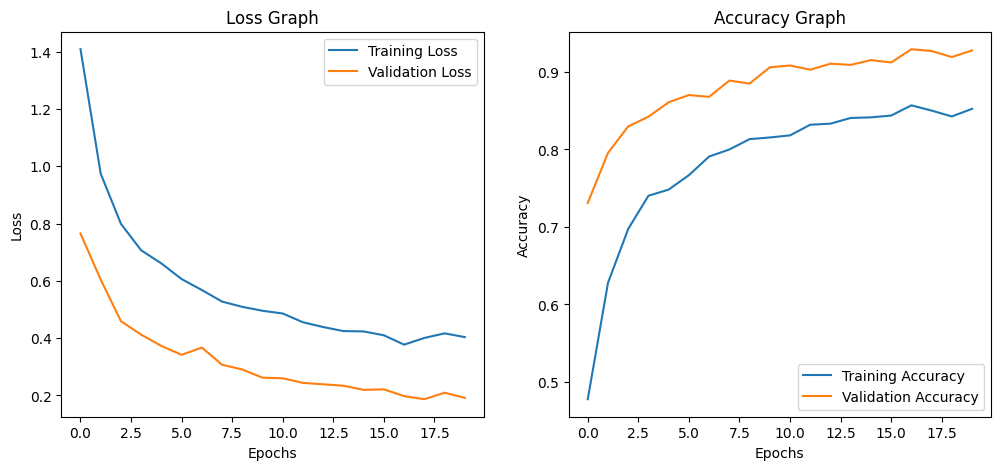

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 924ms/step
Before Fine-Tuning:
                     precision    recall  f1-score   support

         False_smut       0.99      0.96      0.97       188
   bacterial_blight       0.95      0.97      0.96       261
              blast       0.93      0.98      0.95       189
          brownspot       0.96      0.67      0.79       189
grain_discoloration       0.96      0.96      0.96        27
              hispa       0.80      1.00      0.89       190
        leaf_streak       0.96      0.92      0.94        75
      sheath_blight       0.89      1.00      0.94        51
         sheath_rot       0.98      0.91      0.95        67
             tungro       1.00      1.00      1.00        49

           accuracy                           0.93      1286
          macro avg       0.94      0.94      0.94      1286
       weighted avg       0.93      0.93      0.92      1286



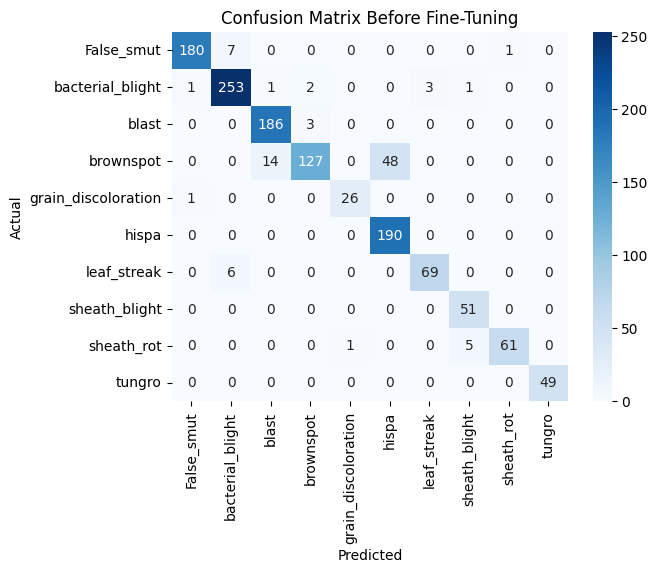

In [ ]:
val_preds = model.predict(valid_generator)
y_true = valid_generator.classes
y_pred = np.argmax(val_preds, axis=1)

# Classification Report
print("Before Fine-Tuning:")
print(classification_report(y_true, y_pred, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Before Fine-Tuning')
plt.show()

In [ ]:
for layer in base_model.layers[:600]:
    layer.trainable = False
for layer in base_model.layers[600:]:
    layer.trainable = True

# Compile Model with Lower Learning Rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 148s 916ms/step - accuracy: 0.9774 - loss: 0.0598 - val_accuracy: 0.9930 - val_loss: 0.0237
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 149s 919ms/step - accuracy: 0.9764 - loss: 0.0750 - val_accuracy: 0.9953 - val_loss: 0.0203
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 146s 900ms/step - accuracy: 0.9793 - loss: 0.0621 - val_accuracy: 0.9922 - val_loss: 0.0220
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 147s 910ms/step - accuracy: 0.9807 - loss: 0.0524 - val_accuracy: 0.9868 - val_loss: 0.0305
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 149s 920ms/step - accuracy: 0.9796 - loss: 0.0566 - val_accuracy: 0.9938 - val_loss: 0.0196


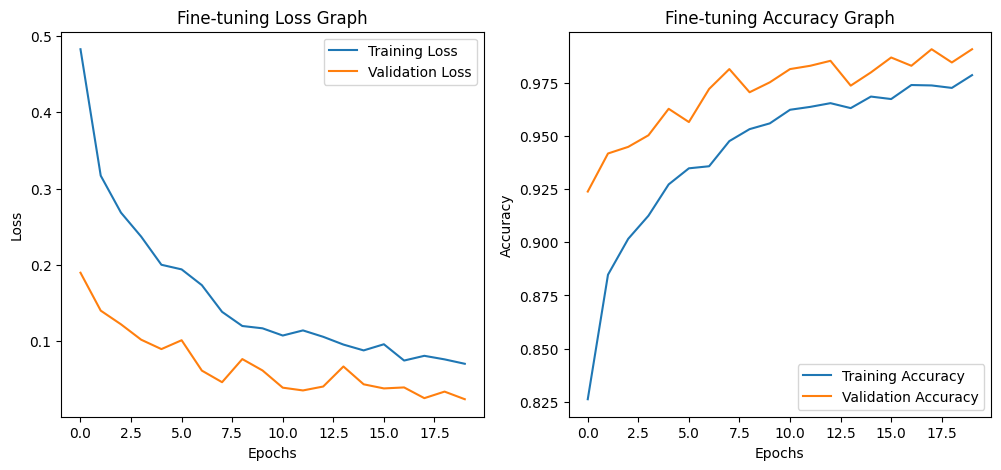

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy values
train_loss_ft = history_finetune.history['loss']
val_loss_ft = history_finetune.history['val_loss']
train_acc_ft = history_finetune.history['accuracy']
val_acc_ft = history_finetune.history['val_accuracy']

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_ft, label='Training Loss')
plt.plot(val_loss_ft, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fine-tuning Loss Graph')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_ft, label='Training Accuracy')
plt.plot(val_acc_ft, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-tuning Accuracy Graph')
plt.legend()

plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 452ms/step
After Fine-Tuning:
                     precision    recall  f1-score   support

         False_smut       1.00      0.99      1.00       188
   bacterial_blight       1.00      0.99      0.99       261
              blast       0.99      1.00      0.99       189
          brownspot       1.00      0.98      0.99       189
grain_discoloration       1.00      1.00      1.00        27
              hispa       0.99      1.00      0.99       190
        leaf_streak       0.96      0.99      0.97        75
      sheath_blight       1.00      1.00      1.00        51
         sheath_rot       1.00      1.00      1.00        67
             tungro       1.00      1.00      1.00        49

           accuracy                           0.99      1286
          macro avg       0.99      1.00      0.99      1286
       weighted avg       0.99      0.99      0.99      1286



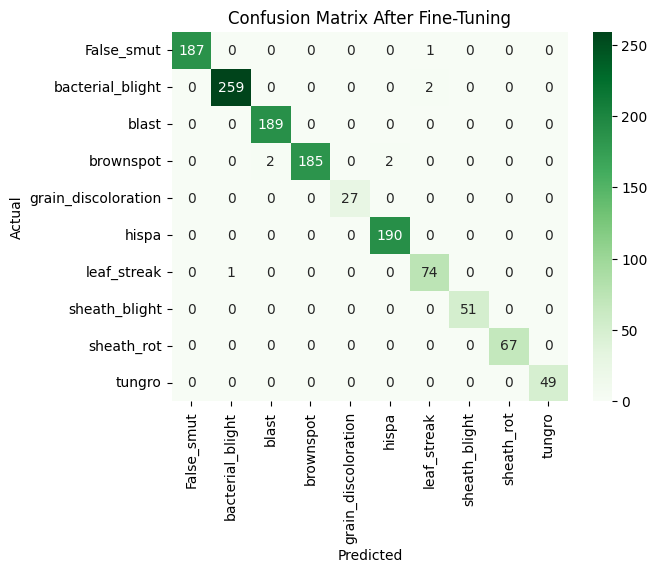

In [ ]:
val_preds_ft = model.predict(valid_generator)
y_pred_ft = np.argmax(val_preds_ft, axis=1)

# Classification Report After Fine-Tuning
print("After Fine-Tuning:")
print(classification_report(y_true, y_pred_ft, target_names=valid_generator.class_indices.keys()))

# Confusion Matrix After Fine-Tuning
cm_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', xticklabels=valid_generator.class_indices.keys(), yticklabels=valid_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix After Fine-Tuning')
plt.show()